<a href="https://colab.research.google.com/github/Nithinps021/Project_IISU/blob/main/Bert_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Nithinps021/Project_IISU.git

Cloning into 'Project_IISU'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 74 (delta 28), reused 18 (delta 5), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [ ]:
!pip install transformers

In [4]:
import json
import numpy as np
import random
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel




# some constant parameters
seq_len=50
batch_size=50
split=0.9


# label class
classes=[]

# data tokenization
def tokenization(data_set):
    xids = np.zeros((num_samples,seq_len))
    xmask = np.zeros((num_samples,seq_len))
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    for i,data in enumerate(data_set):
        tokens=tokenizer.encode_plus(data[0],max_length=seq_len,truncation=True,padding='max_length',add_special_tokens=True,return_tensors='tf')
        xids[i,:]=tokens['input_ids']
        xmask[i,:]=tokens['attention_mask']
    return xids, xmask

def findLabels(data_set):
    for i,j in data_set:
        if j not in classes:
            classes.append(j)
            
    labels = np.zeros((num_samples,len(classes)))
    for i,data in enumerate(data_set):
        labels[i,classes.index(data[1])]=1
    return labels

def mapFunction(xid,xmask,label):
    return {'input_ids':xid,'attention_mask':xmask},label

def preprocessing(xids,xmask,labels):
    dataset= tf.data.Dataset.from_tensor_slices((xids,xmask,labels))
    dataset=dataset.map(mapFunction)
    dataset =dataset.shuffle(10000).batch(batch_size,drop_remainder=True)
    size = int((num_samples/batch_size)*split)
    train=dataset.take(size)
    val_data=dataset.skip(size)
    return train,val_data

def createModel():
    bert = TFBertModel.from_pretrained('bert-base-cased')
    input_ids= tf.keras.layers.Input(shape=(seq_len,),name='input_ids',dtype='int32')
    mask=tf.keras.layers.Input(shape=(seq_len,),name='attention_mask',dtype='int32')
    embedding= bert.bert(input_ids,attention_mask=mask)[1]
    x=tf.keras.layers.Dense(100,activation='relu')(embedding)
    y=tf.keras.layers.Dense(len(classes),activation='softmax',name='output')(x)
    model=tf.keras.Model(inputs=[input_ids,mask],outputs=y)

    optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

    model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

    return model


# data loading part
data_file = open('is_train.json').read()
data_set = json.loads(data_file)
random.shuffle(data_set)
num_samples=len(data_set)

xids,xmask = tokenization(data_set)
labels=findLabels(data_set)
train,validation=preprocessing(xids,xmask,labels)
model = createModel()

history = model.fit(train,epochs=8,validation_data=validation)
model.save('bert_model.h5')

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/8


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


270/270 [==============================] - 135s 466ms/step - loss: 4.6173 - accuracy: 0.0827 - val_loss: 3.6675 - val_accuracy: 0.3360
Epoch 2/8
270/270 [==============================] - 128s 474ms/step - loss: 3.0738 - accuracy: 0.5227 - val_loss: 1.9869 - val_accuracy: 0.7713
Epoch 3/8
270/270 [==============================] - 130s 479ms/step - loss: 1.7331 - accuracy: 0.8236 - val_loss: 0.9417 - val_accuracy: 0.9373
Epoch 4/8
270/270 [==============================] - 131s 484ms/step - loss: 0.9092 - accuracy: 0.9360 - val_loss: 0.4344 - val_accuracy: 0.9800
Epoch 5/8
270/270 [==============================] - 130s 481ms/step - loss: 0.4982 - accuracy: 0.9673 - val_loss: 0.2287 - val_accuracy: 0.9880
Epoch 6/8
270/270 [==============================] - 131s 485ms/step - loss: 0.2990 - accuracy: 0.9806 - val_loss: 0.1422 - val_accuracy: 0.9887
Epoch 7/8
270/270 [==============================] - 131s 485ms/step - loss: 0.1919 - accuracy: 0.9881 - val_loss: 0.0795 - val_accuracy: 0.

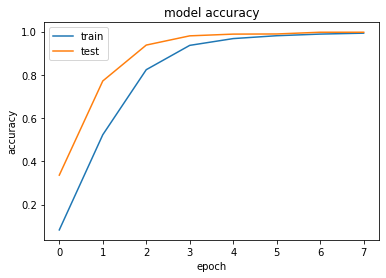

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()